In [282]:
#učitavamo potrebne pakete
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import scipy.stats as stats

(**Napomena:** Neki grafovi se ne prikazuju dobro u .pdf formatu - prekriva ih kod.)

In [283]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [284]:
%cd /content/drive/MyDrive/Projekt UPZ - Netflix

/content/drive/MyDrive/Projekt UPZ - Netflix


U ovom projektu ćemo analizirati podatke iz *netflix_titles.csv* u kojima su spremljene informacije o filmovima/serijama na platformi Netflix.
<br><br>
Učitajmo naše podatke tako da stvorimo DataFrame *data*.

In [422]:
data=pd.read_csv("netflix_titles.csv")

Naš DataFrame se sastoji od 8870 redaka i 12 stupaca.

In [286]:
print(f"Oblik podataka: {data.shape}")

Oblik podataka: (8807, 12)


In [423]:
data.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


Stupac *show_id* nam ne daje nikakvu bitnu/korisnu informaciju (dodatno indexiranje), pa ga možemo izbaciti.

In [287]:
data=data.drop("show_id",axis=1)

Sada imamo 11 stupaca s nazivima koji su izlistani dolje.

In [288]:
print("Nazivi stupaca:")
for col in data.columns:
  print("\t", col)

Nazivi stupaca:
	 type
	 title
	 director
	 cast
	 country
	 date_added
	 release_year
	 rating
	 duration
	 listed_in
	 description


Promotrimo što se nalazi u tim stupcima.<br><br>
*type* - je li govorimo o filmu ili seriji<br>
*title* - naziv filma/serije<br>
*director* - naziv režisera filma/serije<br>
*cast* - glumci koji se pojavljuju u filmu/seriji<br>
*country* - država/e podrijetla<br>
*date_added* - datum dodavanja na Netflix<br>
*release_year* - godina izlaska filma // godina izlaska zadnje sezone serije<br>
*rating* - rating filma/serije (prikladnost)<br>
*duration* - trajanje (minute za film, sezone za seriju)<br>
*listed_in* - kategorija u koju je stavljena serija/film<br>
*description* - opis filma/serije


Provjeravamo postoje li NaN vrijednosti. <br><br>
Postoji ukupno 3475 stupaca sa NaN vrijednostima.

In [290]:
data.isna().any(axis=1).sum()

3475

Stupci *director*, *cast*, *country*, *date_added*, *rating* i *duration* sadrže NaN.

In [291]:
data.isna().any(axis=0)

type            False
title           False
director         True
cast             True
country          True
date_added       True
release_year    False
rating           True
duration         True
listed_in       False
description     False
dtype: bool

Za sada nećemo dirati NaN vrijednosti kako ne bi izbacivali korisne podatke ako ne moramo. Za pojedinačne analize ćemo gledati što nam treba i izbacivati samo ono što nam fali.

**Koliko imamo filmova, a koliko serija?**<br><br>
Ima 6131 filmova i 2676 serije. Ne postoji nikav drugi tip.



In [292]:
data["type"].value_counts()

Movie      6131
TV Show    2676
Name: type, dtype: int64

Razdvojimo naše podatke tako da imamo poseban DataFrame za filmove (*movies*) i poseban za serije (*series*).

In [293]:
series=data[data["type"]=="TV Show"]
movies=data[data["type"]=="Movie"]

Rastavimo našu analizu na više različitih sekcija/poglavlja radi lakšeg snalaženja.

#Analiza ratinga

Stvorimo DataFrame *rate* koji sadrži samo stupac *rating*. Ovo radimo zbog skraćivanja koda.

In [294]:
rate=data["rating"]

Promotrimo jedinstvene vrijednosti ratinga i koliko je svaki rating zastupljen.<br><br>
**Koji ratings su najzastupljeniji?**<br>
"TV-MA" (3207) i "TV-14" (2160) su daleko najzastupljeniji.<br><br>
Promotrimo vrijednosti koje se pojavljuju samo jednom - "74 min", "84 min" i "66 min".

In [295]:
rate.value_counts()

TV-MA       3207
TV-14       2160
TV-PG        863
R            799
PG-13        490
TV-Y7        334
TV-Y         307
PG           287
TV-G         220
NR            80
G             41
TV-Y7-FV       6
NC-17          3
UR             3
74 min         1
84 min         1
66 min         1
Name: rating, dtype: int64

Uočimo da to uopće nisu ratings.<br>
Pozovimo retke u kojima se nalazi takav "rating".<br>
Možemo primijetiti da *duration* stupac za te filmove sadrži NaN vrijednosti. Ovo bi moglo značiti da se dogodila greška pri ispunjavanju podataka - podaci o trajanju filma su upisani u krivi stupac. Ovo ima smisla jer su podaci napisani u istom formatu kao i podaci u stupcu *duration*.

In [296]:
data[(data.rating=="74 min")|(data.rating=="84 min")|(data.rating=="66 min")]

,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
5541,Movie,Louis C.K. 2017,Louis C.K.,Louis C.K.,United States,"April 4, 2017",2017,74 min,NaN,Movies,"Louis C.K. muses on religion, eternal love, gi..."
5794,Movie,Louis C.K.: Hilarious,Louis C.K.,Louis C.K.,United States,"September 16, 2016",2010,84 min,NaN,Movies,Emmy-winning comedy writer Louis C.K. brings h...
5813,Movie,Louis C.K.: Live at the Comedy Store,Louis C.K.,Louis C.K.,United States,"August 15, 2016",2015,66 min,NaN,Movies,The comic puts his trademark hilarious/thought...


Prebacimo te podatke u odgovarajući stupac.

In [297]:
data['duration'] = data['duration'].fillna(data['rating'])

Promotrimo stupac *duration* da vidimo jesmo li u njega ubacili nešto iz stupca *rating* što nismo smjeli.<br>
Iz rezultata koda dolje možemo vidjeti da nema podataka koji su trebali ostati u stupcu *rating*.

In [298]:
data["duration"].unique()

array(['90 min', '2 Seasons', '1 Season', '91 min', '125 min',
       '9 Seasons', '104 min', '127 min', '4 Seasons', '67 min', '94 min',
       '5 Seasons', '161 min', '61 min', '166 min', '147 min', '103 min',
       '97 min', '106 min', '111 min', '3 Seasons', '110 min', '105 min',
       '96 min', '124 min', '116 min', '98 min', '23 min', '115 min',
       '122 min', '99 min', '88 min', '100 min', '6 Seasons', '102 min',
       '93 min', '95 min', '85 min', '83 min', '113 min', '13 min',
       '182 min', '48 min', '145 min', '87 min', '92 min', '80 min',
       '117 min', '128 min', '119 min', '143 min', '114 min', '118 min',
       '108 min', '63 min', '121 min', '142 min', '154 min', '120 min',
       '82 min', '109 min', '101 min', '86 min', '229 min', '76 min',
       '89 min', '156 min', '112 min', '107 min', '129 min', '135 min',
       '136 min', '165 min', '150 min', '133 min', '70 min', '84 min',
       '140 min', '78 min', '7 Seasons', '64 min', '59 min', '139 min',
    

Podatke koje smo prebacili iz stupca *rating* promijenimo u NaN.

In [299]:
data.at[[5541,5794,5813],'rating']=np.nan

Napravimo update na *series*, *movies* i *rate*. U *rate* spremimo koliko ima svakog pojedinog podatka.

In [300]:
series=data[data["type"]=="TV Show"]
movies=data[data["type"]=="Movie"]

In [301]:
rate=data["rating"]
rate=rate.value_counts()

Vizualizirajmo podatke.

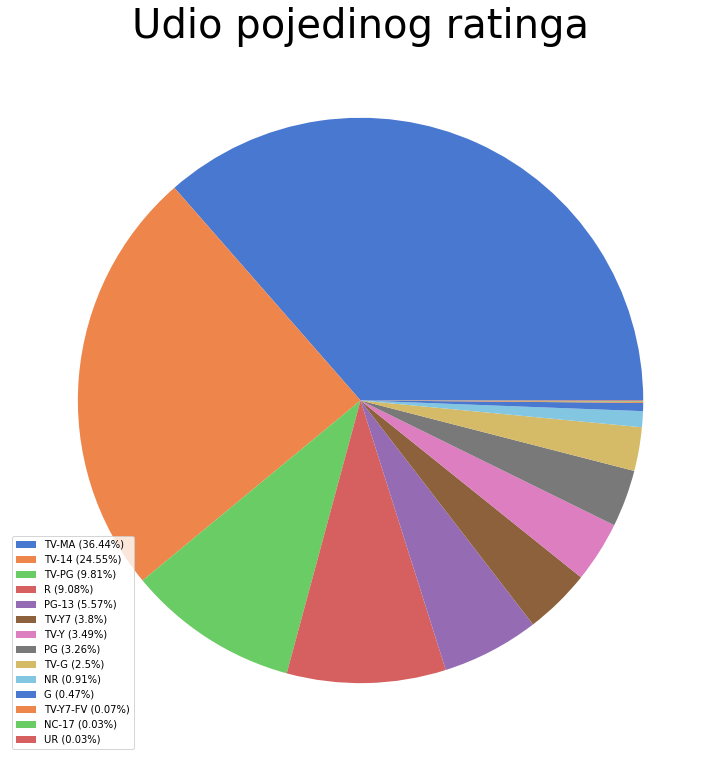

In [302]:
slice_colors = sns.color_palette("muted")

x=[]
for r in rate.values:
  x.append(r/rate.values.sum())

y=[]
for i in range(len(rate.index)):
   y.append(rate.index[i]+" ("+str(round(x[i]*100,2))+"%)")

plt.rc('axes', titlesize=40) 
plt.figure(figsize=(13,13))
plt.pie(rate.values, colors=slice_colors)
plt.legend(y,loc=3)
plt.title("Udio pojedinog ratinga");

#Analiza redatelja

U *direktori* spremimo ukupna pojavljivanja pojedinih redatelja s tim da ne gledamo retke s NaN vrijednostima.

In [303]:
direktori=data[data.director.notna()]["director"].value_counts()

Ispišimo 10 redatelja s najviše pojavljivanja. <br>
Uočimo da "Raúl Campos, Jan Suter" predstavljaju 2 redatelja što znači da je neke filmove/serije režiralo više ljudi.


In [304]:
direktori[:10]

Rajiv Chilaka             19
Raúl Campos, Jan Suter    18
Marcus Raboy              16
Suhas Kadav               16
Jay Karas                 14
Cathy Garcia-Molina       13
Martin Scorsese           12
Youssef Chahine           12
Jay Chapman               12
Steven Spielberg          11
Name: director, dtype: int64

**Koji redatelji su najviše surađivali?**
<br><br>
Daleko najviše filmova su skupa režirali Raúl Campos i Jan Suter.

In [305]:
direktori[[x for x in direktori.index if ',' in x]][:5] #gledamo gdje imamo zarez

Raúl Campos, Jan Suter                                 18
Abbas Alibhai Burmawalla, Mastan Alibhai Burmawalla     4
Munjal Shroff, Tilak Shetty                             3
Lilly Wachowski, Lana Wachowski                         3
Fajar Bustomi, Pidi Baiq                                3
Name: director, dtype: int64

**Koliko filmova/serija je režiralo više od 1 redatelja?**<br>  614.

In [306]:
direktori[[x for x in direktori.index if ',' in x]].sum()

614

Želimo vidjeti i situaciju s pojedinačnim redateljima. Ponovno učitajmo podatke o redateljima, razdvojimo po zarezima i proširimo.

In [307]:
direktori=pd.DataFrame(data[data.director.notna()]["director"])

In [308]:
direktori.director = direktori.director.str.split(', ')                                                               
direktori=direktori.explode('director')

In [309]:
direktori=direktori.director.value_counts()

**Koji redatelj je režirao najviše filmova?**
<br><br>
Rajiv Chilaka (22).<br>
Vizualiziramo kojih 10 redatelja ima najviše filmova.


In [310]:
direktori[:10]

Rajiv Chilaka          22
Jan Suter              21
Raúl Campos            19
Suhas Kadav            16
Marcus Raboy           16
Jay Karas              15
Cathy Garcia-Molina    13
Jay Chapman            12
Youssef Chahine        12
Martin Scorsese        12
Name: director, dtype: int64

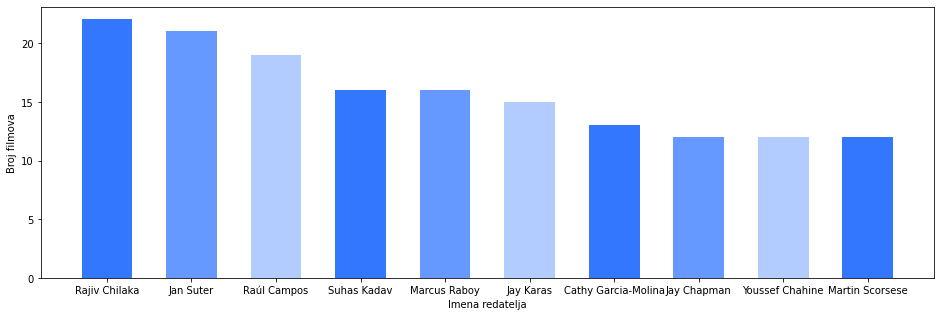

In [311]:
plt.figure(figsize=(16,5))
plt.bar(x=list(direktori.keys())[:10], height=list(direktori.values)[:10], width=0.6,color=["#3377ff","#6699ff","#b3ccff"])
plt.xlabel("Imena redatelja")
plt.ylabel("Broj filmova")
plt.show()

U *dir_zanr* spremimo sve redatelje (koje ćemo rastaviti tako da bude u svakom retku samo 1 redatelj) i kategorije u koje spadaju njihova djela.

In [312]:
dir_zanr=pd.DataFrame(data[data.director.notna()])
dir_zanr=dir_zanr[["director","listed_in"]]
dir_zanr.director = dir_zanr.director.str.split(', ')                                                               
dir_zanr=dir_zanr.explode('director')

Grupirajmo po redatelju tako da zarezom dodamo kategorije (iz drugih redaka) odgovarajućem redatelju.

In [313]:
dir_zanr=dir_zanr.groupby("director",as_index=False).agg({'listed_in': ', '.join})

Promotrit ćemo situaciju za 10 redatelja s najviše filmova.

In [314]:
dir_zanr=dir_zanr[dir_zanr["director"].isin(direktori.keys()[:10])] 

Proširimo i prebrojimo koliko filmova/serija iz koje kategorije je režiser režirao.

In [315]:
dir_zanr.listed_in = dir_zanr.listed_in.str.split(', ')                                                               
dir_zanr=dir_zanr.explode('listed_in')

In [316]:
dir_zanr=dir_zanr.value_counts()

**Koje su najzastupljenije kategorije najpopularnijih režisera?**<br><br>
Ispisano dolje - postotak predstavlja udio te kategorije među ukupnim im filmovima. <br>Uočimo da je npr. Chilaka režirao većinom (obiteljske) filmove za djecu, a Suter i Campos isključivo stand-up.<br>
Najpopularniji žanr među najpopularnijim režiserima je Stand-Up Comedy.

In [317]:
for k in direktori.keys()[:10]:
  print(k," ",dir_zanr[k].index[0]," ",round((dir_zanr[k][0]/(dir_zanr[k].values.sum()))*100,2)," %")

Rajiv Chilaka   Children & Family Movies   91.67  %
Jan Suter   Stand-Up Comedy   100.0  %
Raúl Campos   Stand-Up Comedy   100.0  %
Suhas Kadav   Children & Family Movies   55.17  %
Marcus Raboy   Stand-Up Comedy   88.24  %
Jay Karas   Stand-Up Comedy   82.35  %
Cathy Garcia-Molina   International Movies   35.14  %
Jay Chapman   Stand-Up Comedy   92.31  %
Youssef Chahine   Dramas   36.36  %
Martin Scorsese   Dramas   36.0  %


#O državama

U *drzave* spremimo sve vrijednosti iz stupca *country* koje nisu NaN radi lakšeg snalaženja.

In [318]:
drzave=pd.DataFrame(data[data.country.notna()]["country"])

Pošto su neki filmovi/serije snimani u više država (odvojeno zarezom), proširit ćemo DataFrame tako da u svakom retku imamo po jednu državu. Spremimo u *drzave* koliko se svaka država pojavljuje puta.

In [319]:
drzave.country = drzave.country.str.split(', ')                                                               
drzave=drzave.explode('country')
drzave=drzave.value_counts()

**U kojoj državi se snimalo najviše filmova/serija?**<br><br>
U SAD-u (3689).<br>
Mnogo filmova/serija je također snimano u Indiji i UK-u.

In [320]:
drzave[:10]

country       
United States     3689
India             1046
United Kingdom     804
Canada             445
France             393
Japan              318
Spain              232
South Korea        231
Germany            226
Mexico             169
dtype: int64

Vizulaizirajmo podatke s pie chartom. <br>
Uzet ćemo vrijednosti prvih 10 najzastupljenijih država, a ostale države ćemo označiti s "Ostalo".

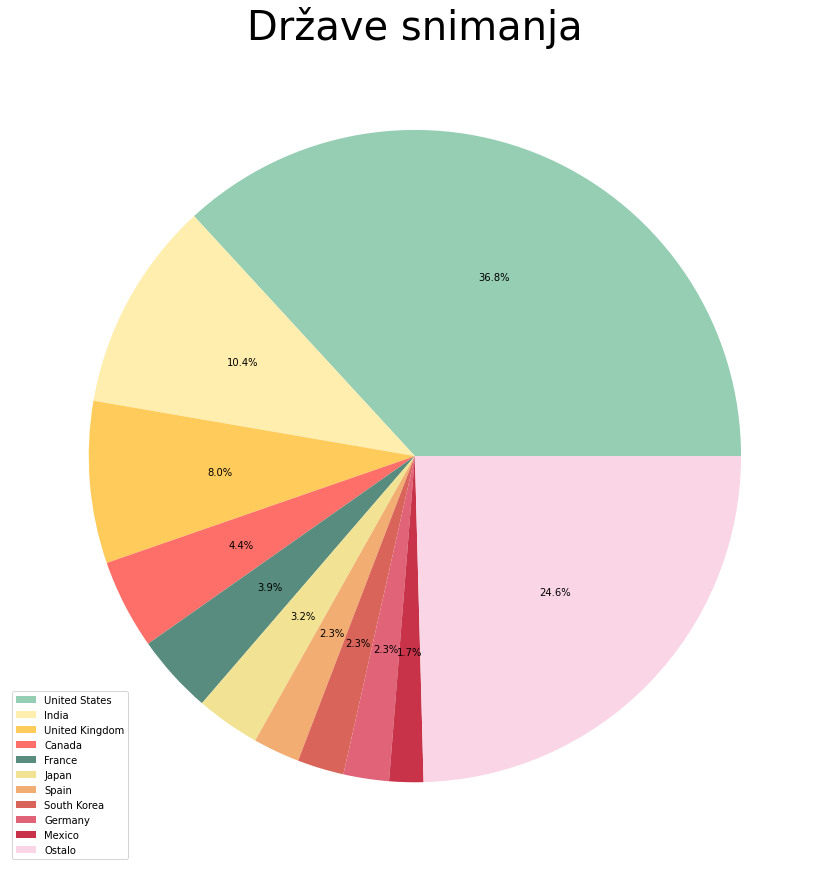

In [321]:
slice_colors = sns.color_palette(["#96ceb4","#ffeead","#ffcc5c","#ff6f69","#588c7e","#f2e394","#f2ae72","#d96459","#e06377","#c83349","#f9d5e5"])

lab=[x[0] for x in drzave.keys()[:10]]
lab.append("Ostalo") #labela za ostale države

val=[x for x in drzave.values[:10]]
x=drzave.values.sum()-sum(val) #od ukupnog broja država snimanja oduzimamo broj snimanja u top 10 država kako bi dobili preostale
val.append(x)

plt.rc('axes', titlesize=40) 
plt.figure(figsize=(15,15))
plt.pie(val, colors=slice_colors,autopct='%.1f%%')
plt.legend(lab,loc=3)
plt.title("Države snimanja");

Pošto su indexi u *drzave* tipa *tuple* (što nije potrebno jer druge vrijednosti nema), izmijeniti ćemo indexe tako da imamo samo string imena države.

In [322]:
drzave.index[0]

('United States',)

In [323]:
drzave.index=[x[0] for x in drzave.index]

Promotrimo u kojim državama su glumili koji glumci.<br><br>
U *glum_drzava* spremimo podatke iz stupaca *cast* i *country* tako da ne uzimamo nikakve NaN podatke.<br>
Prvo proširimo DataFrame obzirom na države (poseban redak za svaku državu). <br>
Izbacimo duplikate ako postoje i grupirajmo podatke po državi - na jednu državu dodajemo sve glumce koji su glumili u toj državi (ponavljamo ih ako su glumili više puta).<br><br>
Promotrimo samo podatke za 10 najčešćih država.<br>
Proširimo DataFrame obzirom na glumce (svaki glumac svoj red) i prebrojimo sva njihova pojavljivanja obzirom na državu.

In [324]:
glum_drzava=pd.DataFrame(data[data.cast.notna() & data.country.notna()])
glum_drzava=glum_drzava[["cast","country"]]
glum_drzava.country = glum_drzava.country.str.split(', ')                                                               
glum_drzava=glum_drzava.explode('country')
glum_drzava.drop_duplicates(subset = "cast", keep =  "last", inplace = True)
glum_drzava=glum_drzava.groupby("country",as_index=False).agg({'cast': ', '.join})
glum_drzava=glum_drzava[glum_drzava["country"].isin(drzave.keys()[:10])] #top 10
glum_drzava.cast = glum_drzava.cast.str.split(', ')                                                               
glum_drzava=glum_drzava.explode('cast')
glum_drzava=glum_drzava.value_counts()

**Koji se glumci najviše pojavljuju u 10 najčešćih država?**

In [325]:
br=1
for k in drzave.keys()[:10]:
  print(br,". ",k," - ",glum_drzava[k].index[0]," (",glum_drzava[k][0],")")
  br+=1

1 .  United States  -  Samuel L. Jackson  ( 20 )
2 .  India  -  Anupam Kher  ( 40 )
3 .  United Kingdom  -  Terry Jones  ( 11 )
4 .  Canada  -  Robb Wells  ( 14 )
5 .  France  -  Wille Lindberg  ( 5 )
6 .  Japan  -  Takahiro Sakurai  ( 28 )
7 .  Spain  -  Mario Casas  ( 9 )
8 .  South Korea  -  Sung Dong-il  ( 6 )
9 .  Germany  -  Wotan Wilke Möhring  ( 4 )
10 .  Mexico  -  Humberto Busto  ( 5 )


**Vizualizirajmo odnos snimljenih serija i filmova u 10 najčešćih država.**

([<matplotlib.axis.XTick at 0x7f4e02927370>,
 [Text(0, 0, 'United States'),
  Text(0, 0, 'India'),
  Text(0, 0, 'United Kingdom'),
  Text(0, 0, 'Canada'),
  Text(0, 0, 'France'),
  Text(0, 0, 'Japan'),
  Text(0, 0, 'Spain'),
  Text(0, 0, 'South Korea'),
  Text(0, 0, 'Germany'),
  Text(0, 0, 'Mexico')])

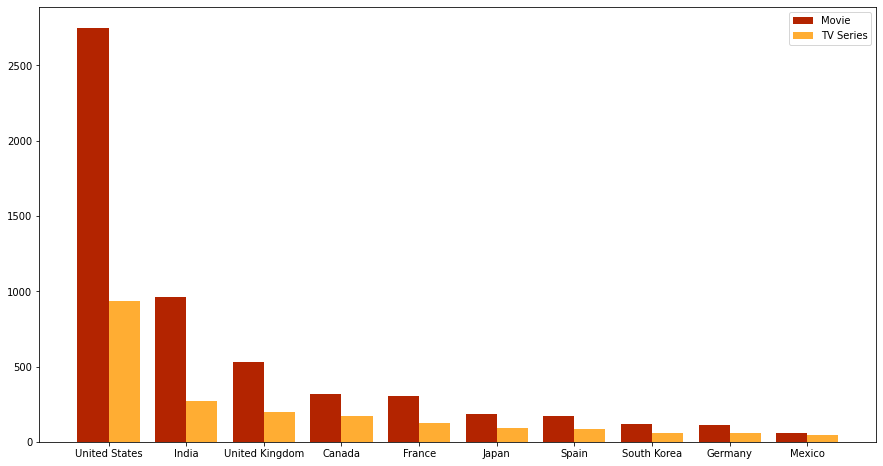

In [326]:
#ponavljamo postupak od prije, ali posebno za filmove i serije
tip_drzavaM=pd.DataFrame(movies[movies.country.notna()]["country"])
tip_drzavaS=pd.DataFrame(series[series.country.notna()]["country"])
tip_drzavaM.country = tip_drzavaM.country.str.split(', ')                                                               
tip_drzavaM=tip_drzavaM.explode('country')
tip_drzavaM=tip_drzavaM[tip_drzavaM["country"].isin(drzave.keys()[:10])]
tip_drzavaS.country = tip_drzavaS.country.str.split(', ')                                                               
tip_drzavaS=tip_drzavaS.explode('country')
tip_drzavaS=tip_drzavaS[tip_drzavaS["country"].isin(drzave.keys()[:10])]
tip_drzavaM=tip_drzavaM.value_counts()
tip_drzavaS=tip_drzavaS.value_counts()

#plot
plt.figure(figsize=(15,8))
X_axis = np.arange(10)
plt.bar(X_axis - 0.2, tip_drzavaM, 0.4, label = 'Movies', color="#b32400")
plt.bar(X_axis + 0.2, tip_drzavaS, 0.4, label = 'Series', color="#ffad33")
plt.legend(["Movie","TV Series"],loc=1)
plt.xticks(X_axis, lab)

Možemo vidjeti da u svim državama je snimljeno barem duplo filmova nego serija. USA ima daleko više i filmova i serija s tim da je u SAD-u snimljeno za više od 1000 filmova nego serija (koji su stavljeni na Netflix).<br>
Indija npr. ima jako malo serija u odnosu na filmove, a snimljenih filmova ima tek malo više od serija snimljenih u SAD-u.

#Analiza glumaca

U *glumci* učitajmo stupac *cast* s vrijednostima koje nisu NaN i proširimo DataFrame tako da imamo samo jednog glumca po retku.

In [327]:
glumci=pd.DataFrame(data[data.cast.notna()]["cast"])

In [328]:
glumci.cast = glumci.cast.str.split(', ')                                                               
glumci=glumci.explode('cast')
glumci=glumci.cast.value_counts()

**Koliko ukupno glumaca se pojavljuje na Netflix-u?**

In [329]:
print("Na Netflix-u se pojavljuje",len(glumci),"glumaca.")

Na Netflix-u se pojavljuje 36439 glumaca.


**Koji glumac/glumica je glumio/a u najviše filmova/serija?**
<br><br>
Anupam Kher se pojavljuje u 43 filma/serije na Netflixu.<br><br>
Vizualizirajmo 10 najčešćih glumaca sa stupčanim dijagramom.

In [330]:
glumci[:10]

Anupam Kher         43
Shah Rukh Khan      35
Julie Tejwani       33
Naseeruddin Shah    32
Takahiro Sakurai    32
Rupa Bhimani        31
Akshay Kumar        30
Om Puri             30
Yuki Kaji           29
Paresh Rawal        28
Name: cast, dtype: int64

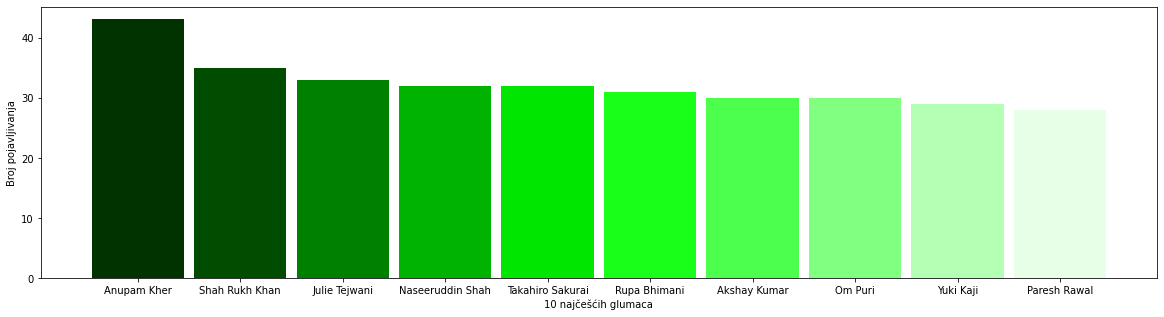

In [331]:
plt.figure(figsize=(20,5))
plt.bar(x=list(glumci.keys())[:10], height=list(glumci.values)[:10], width=0.9,color=["#003300","#004d00","#008000","#00b300","#00e600","#1aff1a","#4dff4d","#80ff80","#b3ffb3","#e6ffe6"])
plt.xlabel("10 najčešćih glumaca")
plt.ylabel("Broj pojavljivanja")
plt.show()

Zanima nas u kakvim filmovima/serijama su glumili ovi glumci.<br><br>
Spremimo stupce *cast* i *listed_in* (bez NaN) u *glum_zanr*. Proširit ćemo DataFrame po glumcima kao i prije, pa grupirati po njima tako da uz jednog glumca stoje sve kategorije filmova/serija u kojima se pojavljuje.<br>
Nas zanima 10 najčešćih glumaca. <br>
Proširimo po kategorijama i prebrojavamo broj pojavljivanja u kategoriji po glumcu.

In [332]:
glum_zanr=pd.DataFrame(data[data.cast.notna()])
glum_zanr=glum_zanr[["cast","listed_in"]]
glum_zanr.cast = glum_zanr.cast.str.split(', ')                                                               
glum_zanr=glum_zanr.explode('cast')
glum_zanr=glum_zanr.groupby("cast",as_index=False).agg({'listed_in': ', '.join})
glum_zanr=glum_zanr[glum_zanr["cast"].isin(glumci.keys()[:10])] #top 10
glum_zanr.listed_in = glum_zanr.listed_in.str.split(', ')                                                               
glum_zanr=glum_zanr.explode('listed_in')
glum_zanr=glum_zanr.value_counts()

**Koje su najčešće kategorije filmova/serija najzastupljenijih glumaca?**<br><br>
*postotak predstavlja udio pojavljivanja baš te kategorije među svim kategorijama u kojima se spomenuti glumac pojavljuje

In [333]:
print("Top 10 glumaca i njihove najčešće kategorije:")
br=1
for k in glumci.keys()[:10]:
  print(br,". ",k," - ",glum_zanr[k].index[0]," - ",round((glum_zanr[k][0]/(glum_zanr[k].values.sum()))*100,2)," %")
  br+=1

Top 10 glumaca i njihove najčešće kategorije:
1 .  Anupam Kher  -  International Movies  -  31.67  %
2 .  Shah Rukh Khan  -  International Movies  -  32.32  %
3 .  Julie Tejwani  -  Children & Family Movies  -  76.47  %
4 .  Naseeruddin Shah  -  Dramas  -  30.43  %
5 .  Takahiro Sakurai  -  Anime Series  -  32.0  %
6 .  Rupa Bhimani  -  Children & Family Movies  -  78.12  %
7 .  Akshay Kumar  -  International Movies  -  31.76  %
8 .  Om Puri  -  International Movies  -  34.62  %
9 .  Yuki Kaji  -  Anime Series  -  24.66  %
10 .  Paresh Rawal  -  International Movies  -  31.65  %


Većimo se postotak gornjeg rezultata vrti oko 30% što upućuje na raznolikost kategorija. Npr. "Takahiro Sakurai" se pojavljuje u 11 različitih kategorija filmova. Prikažimo to pie chartom.

In [334]:
len(glum_zanr["Takahiro Sakurai"])

11

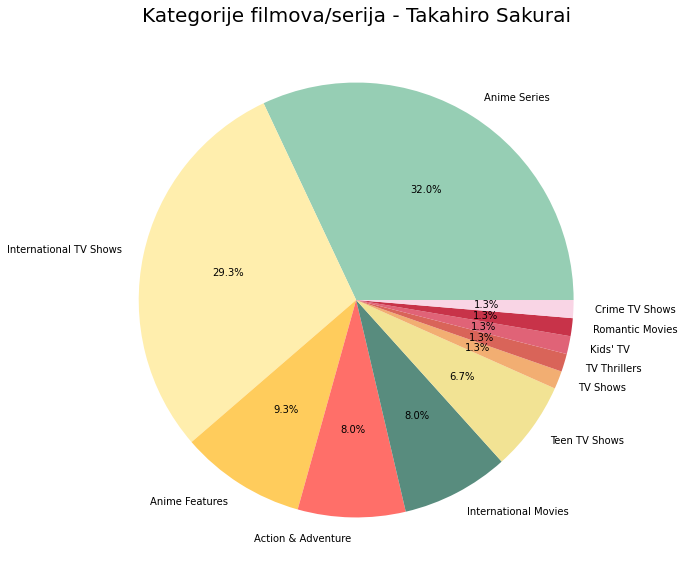

In [335]:
slice_colors = sns.color_palette(["#96ceb4","#ffeead","#ffcc5c","#ff6f69","#588c7e","#f2e394","#f2ae72","#d96459","#e06377","#c83349","#f9d5e5","pink"])

plt.rc('axes', titlesize=20) 
plt.figure(figsize=(10,10))
plt.pie(glum_zanr["Takahiro Sakurai"].values,labels=glum_zanr["Takahiro Sakurai"].keys(), colors=slice_colors,autopct='%.1f%%')
plt.title("Kategorije filmova/serija - Takahiro Sakurai");

Možemo primijetiti da je dosta glumaca većinski glumilo u internacionalnim filmovima. Bilo bi dobro provjeriti i njihove najzastupljenije države. Napravimo sličan postupak kao prethodni (*glum_zanr*). Sada nas zanima u kojim državama su najviše glumili spomenuti glumci.

In [336]:
glum_drzava=pd.DataFrame(data[data.cast.notna() & data.country.notna()])
glum_drzava=glum_drzava[["cast","country"]]
glum_drzava.cast = glum_drzava.cast.str.split(', ')                                                               
glum_drzava=glum_drzava.explode('cast')
glum_drzava=glum_drzava.groupby("cast",as_index=False).agg({'country': ', '.join})
glum_drzava=glum_drzava[glum_drzava["cast"].isin(glumci.keys()[:10])] #top 10
glum_drzava.country = glum_drzava.country.str.split(', ')                                                               
glum_drzava=glum_drzava.explode('country')
glum_drzava=glum_drzava.value_counts()

**Koje su najčešće države snimanja najzastupljenijih glumaca?**

In [337]:
print("Top 10 glumaca i njihove države:")
br=1
for k in glumci.keys()[:10]:
  print(br,". ",k," - ",glum_drzava[k].index[0]," - ",round((glum_drzava[k][0]/(glum_drzava[k].values.sum()))*100,2)," %")
  br+=1

Top 10 glumaca i njihove države:
1 .  Anupam Kher  -  India  -  86.96  %
2 .  Shah Rukh Khan  -  India  -  91.89  %
3 .  Julie Tejwani  -  India  -  100.0  %
4 .  Naseeruddin Shah  -  India  -  93.94  %
5 .  Takahiro Sakurai  -  Japan  -  100.0  %
6 .  Rupa Bhimani  -  India  -  100.0  %
7 .  Akshay Kumar  -  India  -  93.55  %
8 .  Om Puri  -  India  -  82.86  %
9 .  Yuki Kaji  -  Japan  -  100.0  %
10 .  Paresh Rawal  -  India  -  93.33  %


Svi glumci su pretežno glumili u istim državama. 
<br>
Od 10 najčešćih glumaca, čak 8 ih je većinom glumilo u Indiji, a 2 u Japanu.
<br>
Kao što smo pokazali ranije, Indija je druga najčešća država po broju filmova/serija snimljenih u njoj, pa ovaj podatak ima smisla.
<br><br>
Možemo se još zapitati zašto među najčešćim glumcima nema niti jednog kojemu je najzastupljenija država SAD ako smo utvrdili da je SAD prva po broju snimljenih filmova/serija?<br><br>
Ako pogledamo filmove/serije koji su snimani samo u Indiji i samo u SAD-u (bez filmova/serija snimanih na više lokacija), možemo vidjeti da filmova snimljenih u SAD-u ima duplo više, pa nije riječ o količini.<br>
Najjednostavnija pretpostavka bi bila da je Netflix birao raznovrsnije filmove u SAD-u ("domaće tržište"), a iz Indije je uzimao filmove sa provjereno popularnim glumcima.


In [338]:
print("Filmovi Indija: ",len(data[data.country=="India"]))
print("Filmovi SAD: ",len(data[data.country=="United States"]))

Filmovi Indija:  972
Filmovi SAD:  2818


#Analiza kategorija

U *tags* spremimo vrijednosti iz stupca *listed_in* koje nisu NaN.

In [339]:
tags=pd.DataFrame(data[data.listed_in.notna()]["listed_in"])
tags.listed_in = tags.listed_in.str.split(', ')                                                               
tags=tags.explode('listed_in')

**10 najzastupljenijih kategorija?**<br><br>
(najpopularniji većinom internacionalni filmovi i drame)

In [340]:
tags=tags.listed_in.value_counts()
tags[:10]

International Movies        2752
Dramas                      2427
Comedies                    1674
International TV Shows      1351
Documentaries                869
Action & Adventure           859
TV Dramas                    763
Independent Movies           756
Children & Family Movies     641
Romantic Movies              616
Name: listed_in, dtype: int64

**5 najmanje *zastupljenih* kategorija?**<br><br>
(najmanje zastupljeni TV Shows)

In [341]:
tags[-5:]

TV Thrillers                    57
Movies                          57
Stand-Up Comedy & Talk Shows    56
Classic & Cult TV               28
TV Shows                        16
Name: listed_in, dtype: int64

**Koliko ukupno ima kategorija?**

In [342]:
print("Ukupno ima ",len(tags)," različite kategorije.")

Ukupno ima  42  različite kategorije.


Promotrimo posebno za filmove i za serije.<br><br>
**10 najzastupljenijih kategorija u filmovima?**

In [343]:
tags_m=pd.DataFrame(movies[movies.listed_in.notna()]["listed_in"])
tags_m.listed_in = tags_m.listed_in.str.split(', ')                                                               
tags_m=tags_m.explode('listed_in')
tags_m_count=tags_m.listed_in.value_counts()
tags_m_count[:10]

International Movies        2752
Dramas                      2427
Comedies                    1674
Documentaries                869
Action & Adventure           859
Independent Movies           756
Children & Family Movies     641
Romantic Movies              616
Thrillers                    577
Music & Musicals             375
Name: listed_in, dtype: int64

**5 najmanje *zastupljenih* kategorija u filmovima?**

In [344]:
tags_m_count[-5:]

LGBTQ Movies            102
Anime Features           71
Cult Movies              71
Faith & Spirituality     65
Movies                   57
Name: listed_in, dtype: int64

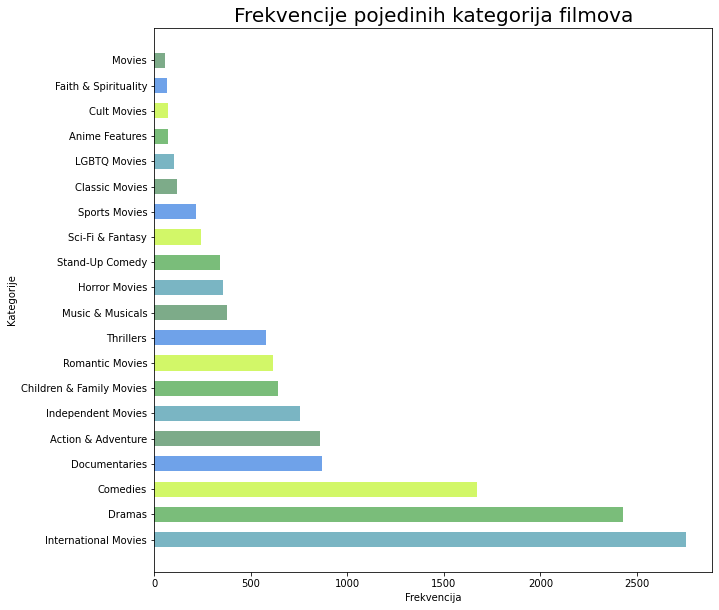

In [345]:
plt.subplots(figsize=(10, 10)) 
plt.barh(y=tags_m_count.keys(), width= tags_m_count.values, height=0.6, alpha = 0.6, color=['#21849B', '#219121', '#B4F204', '#0F65DB', '#26733B'])

plt.xlabel('Frekvencija')
plt.ylabel('Kategorije')
plt.title('Frekvencije pojedinih kategorija filmova')

plt.show()

**10 najzastupljenijih kategorija u serijama?**<br><br>
Primijetimo kako su internacionalni i drame najzastupljeniji i u filmovima i u serijama.

In [346]:
tags_s=pd.DataFrame(series[series.listed_in.notna()]["listed_in"])
tags_s.listed_in = tags_s.listed_in.str.split(', ')                                                               
tags_s=tags_s.explode('listed_in')
tags_s_count=tags_s.listed_in.value_counts()
tags_s_count[:10]

International TV Shows    1351
TV Dramas                  763
TV Comedies                581
Crime TV Shows             470
Kids' TV                   451
Docuseries                 395
Romantic TV Shows          370
Reality TV                 255
British TV Shows           253
Anime Series               176
Name: listed_in, dtype: int64

**5 najmanje zastupljenih kategorija u serijama?**

In [347]:
tags_s_count[-5:]

Teen TV Shows                   69
TV Thrillers                    57
Stand-Up Comedy & Talk Shows    56
Classic & Cult TV               28
TV Shows                        16
Name: listed_in, dtype: int64

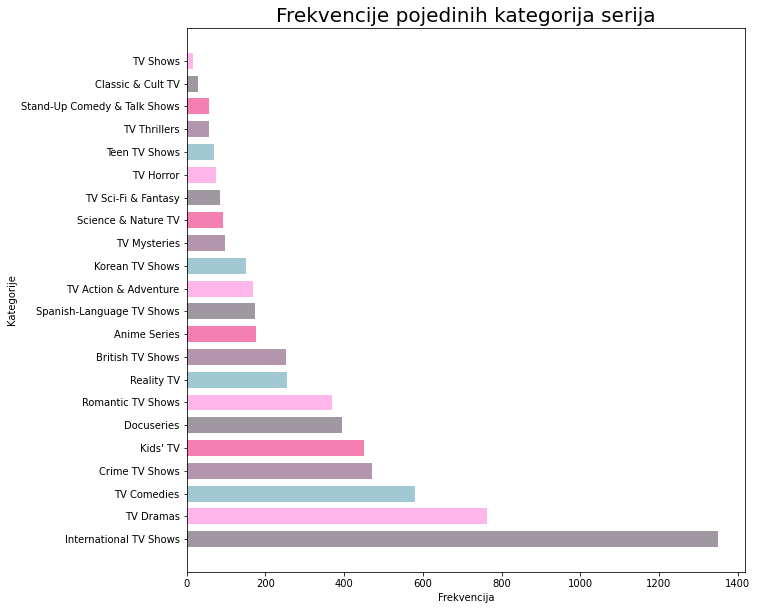

In [348]:
plt.subplots(figsize=(10, 10)) 
plt.barh(y=tags_s_count.keys(), width= tags_s_count.values, height=0.7, alpha = 0.5, color=['#403343', '#FF71D8', '#4295AA', '#692F5D', '#E90362'])

plt.xlabel('Frekvencija')
plt.ylabel('Kategorije')
plt.title('Frekvencije pojedinih kategorija serija')

plt.show()

**Koliko različitih kategorija ima za filmove, koliko za serije?**


In [349]:
print("Broj kategorija u filmovima: ",len(tags_m_count))
print("Broj kategorija u serijama: ",len(tags_s_count))

Broj kategorija u filmovima:  20
Broj kategorija u serijama:  22


Uočimo da iako na Netflixu ima više filmova, postoji više kategorija za serije.

#Analiza opisa

U *desc* spremimo podatke iz stupca *description* (nema potrebe micati NaN jer smo na početku utvrdili da ovaj stupac nema NaN). U *df_desc* spremamo iste podatke kao i u *desc*, ali u DataFrame obliku.<br>
U *titles* spremamo nazive u numpy obliku. 

In [350]:
desc=data["description"]
titles=data["title"].to_numpy()

In [351]:
df_desc=pd.DataFrame(data["description"])

In [352]:
#učitavamo pakete za tokenizaciju
import nltk
from nltk import tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english') #stopwords - pomoćne riječi koje se pojavljuju najčešće, a ne izražavaju neki korisni sentiment

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Promotrimo varijancu. Napravimo funkciju *var_desc* koja će računati varijancu iz liste koja sadrži duljine riječi u opisu pojednog djela.

In [353]:
def var_desc(row): 
    l = []
    for i in row: #za svaku riječ
      l.append(len(i.split())) #duljina riječi
    return np.var(l)

Stvorimo nove stupce *number_of_words* (u koji ćemo spremiti broj riječi po opisu) i *variance_od_word_lengths* (u koji spremamo varijancu duljina riječi po opisu).

In [354]:
df_desc["numer_of_words"] = df_desc["description"].apply(lambda x: len(x.split())) 
df_desc["variance_of_word_lengths"] = df_desc["description"].apply(lambda x: var_desc(x))

Promotrimo distribuciju riječi po pojedinom opisu. <br><br>
**Koliki je prosječan broj riječi po opisu?**<br><br>
Vidimo da većina opisa ima oko 25 riječi.

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribucija duljina opisa')

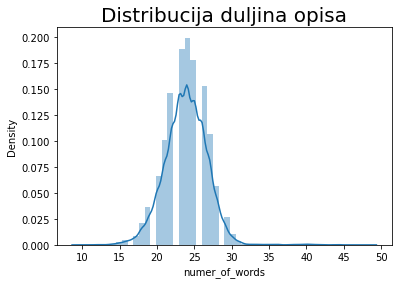

In [355]:
sns.distplot(df_desc["numer_of_words"]).set_title("Distribucija duljina opisa")

Visualizirajmo sa *distplot* i odnos varijanci duljina riječi.

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Varijance duljina riječi')

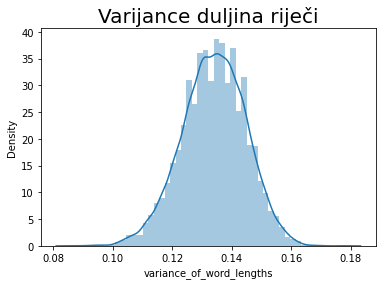

In [356]:
sns.distplot(df_desc["variance_of_word_lengths"]).set_title("Varijance duljina riječi")

**Jesu li varijance duljina riječi normalno distribuirane?** <br>
Hipoteze:
> * $H_0$: podaci normalno distriburiani
> * $H_1$: podaci nisu normalno distribuirani

Uzmimo da je razina značajnosti $\alpha = P(pogreška \hspace{1mm}prve \hspace{1mm} vrste)=0.05$.<br>
Gledamo je li $p$-vrijednost < ili >= $\alpha$ i ovisno o tome odbacujemo ili ne odbacujemo nul-hipotezu $H_0$ (ako manje od 0.05 odbacujemo).<br><br>
Koristimo test koji ispituje normalnu distribuciju.


In [357]:
statistic, pvalue = stats.normaltest(df_desc["variance_of_word_lengths"])
print(f"pvalue: {pvalue}")
print(f"pvalue < 0.05: {pvalue < 0.05}")

pvalue: 8.528175862211174e-12
pvalue < 0.05: True


$p$-vrijednost je manja od $\alpha$, pa odbacujemo nultu hipotezu tj. podaci nisu normalno distribuirani.

Stvaramo riječnik *dict_title* u kojeg kao ključeve spremamo nazive, a pridružujemo ih broj riječi u tom nazivu.

In [358]:
dict_title={}
for t in titles:
  words = t.split(" ")
  dict_title[t]=len(words)
  

**Koji film/serija ima najdulji naslov?**

In [359]:
print("Najdulji naslov: ", max(dict_title, key=lambda x : dict_title[x]))

Najdulji naslov:  Jim & Andy: The Great Beyond - Featuring a Very Special, Contractually Obligated Mention of Tony Clifton


Posebno gledajmo podatke za serije (*tags_s*) i za filmove (*tags_m*).<br>
U DataFrame-ove spremimo, osim opisa, i kategorije i nazive.<br>
Proširimo po kategorijama kao i prije.

In [360]:
tags_m=pd.DataFrame(movies[movies.listed_in.notna()][["title","listed_in","description"]])
tags_m.listed_in = tags_m.listed_in.str.split(', ')                                                               
tags_m=tags_m.explode('listed_in')
tags_s=pd.DataFrame(series[series.listed_in.notna()][["listed_in","description"]])
tags_s.listed_in = tags_s.listed_in.str.split(', ')                                                               
tags_s=tags_s.explode('listed_in')

In [361]:
word_tokenizer = tokenize.TreebankWordTokenizer() #alat za tokenizaciju

U *desc_m* spremamo opise 10 najzastupljenijih kategorija filmova.

In [362]:
desc_m=tags_m[tags_m["listed_in"].isin(tags_m_count.keys()[:10])]
desc_m=desc_m.description.to_numpy()
desc_m=[*set(desc_m)]

Cijepamo svaki opis na riječi (*sentences_with_words*) i sve stavljamo u 1 listu (*words*).

In [363]:
sentences_with_words = word_tokenizer.tokenize_sents(desc_m)

In [364]:
words = [word for sentence in sentences_with_words for word in sentence]

**Koje riječi se najčešće pojavljuju u opisima 10 najčešćih kategorija filmova?**

In [365]:
from collections import Counter
counter_words = Counter() #brojač

for word in words:
    if word.lower() not in stop_words and word.isalnum():
      counter_words.update({word})

counter_words.most_common(10)

[('young', 527),
 ('life', 480),
 ('man', 408),
 ('family', 392),
 ('woman', 364),
 ('new', 326),
 ('documentary', 305),
 ('love', 303),
 ('must', 293),
 ('two', 245)]

Najviše se pojavljuju riječi "young", "life" i "man", a ostale ćemo riječi vizualizirati s WordCloud-om.

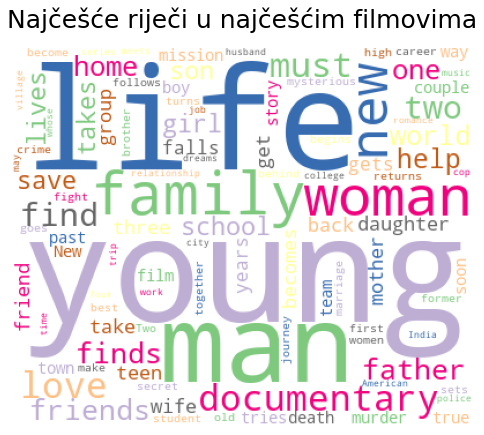

In [366]:
from wordcloud import WordCloud
fig = plt.figure(figsize=(15, 7))

wc = WordCloud(width=400, height=330, max_words=100, colormap="Accent", background_color="white").generate_from_frequencies(counter_words)

plt.imshow(wc)
plt.axis("off")
plt.title("Najčešće riječi u najčešćim filmovima", fontsize=25, pad=20);

**Koje riječi se najčešće pojavljuju u opisima 10 najmanje čestih kategorija filmova?**

In [367]:
desc_m=tags_m[tags_m["listed_in"].isin(tags_m_count.keys()[-10:])]
desc_m=desc_m.description.to_numpy()
desc_m=[*set(desc_m)]
sentences_with_words = word_tokenizer.tokenize_sents(desc_m)
words = [word for sentence in sentences_with_words for word in sentence]

from collections import Counter
counter_words = Counter()

for word in words:
    if word.lower() not in stop_words and word.isalnum():
      counter_words.update({word})

counter_words.most_common(10)

[('life', 122),
 ('special', 118),
 ('young', 99),
 ('new', 90),
 ('family', 81),
 ('takes', 80),
 ('woman', 72),
 ('comedian', 72),
 ('comedy', 68),
 ('home', 67)]

To su "life", "special" i "young". Zanimljivo je da se riječi koje se pojavljuju u opisima najčešćih filmova, pojavljuju i u opisima najrjeđih. (Vizualizirajmo.)

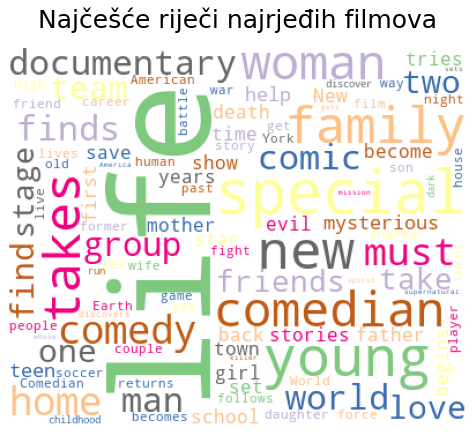

In [368]:
from wordcloud import WordCloud
fig = plt.figure(figsize=(15, 7))

wc = WordCloud(width=400, height=330, max_words=100, colormap="Accent", background_color="white").generate_from_frequencies(counter_words)

plt.imshow(wc)
plt.axis("off")
plt.title("Najčešće riječi najrjeđih filmova", fontsize=25, pad=20);

Postupak ponavljamo i za serije.<br><br>
**Koje riječi se najčešće pojavljuju u opisima 10 najčešćih kategorija serija?**

In [369]:
desc_s=tags_s[tags_s["listed_in"].isin(tags_s_count.keys()[:10])]
desc_s=desc_s.description.to_numpy()
desc_s=[*set(desc_s)]
sentences_with_words = word_tokenizer.tokenize_sents(desc_s)
words = [word for sentence in sentences_with_words for word in sentence]

from collections import Counter
counter_words1 = Counter()

for word in words:
    if word.lower() not in stop_words and word.isalnum():
      counter_words1.update({word})

counter_words1.most_common(10)



[('series', 301),
 ('life', 243),
 ('world', 220),
 ('new', 191),
 ('family', 180),
 ('friends', 179),
 ('young', 156),
 ('love', 155),
 ('school', 120),
 ('two', 104)]

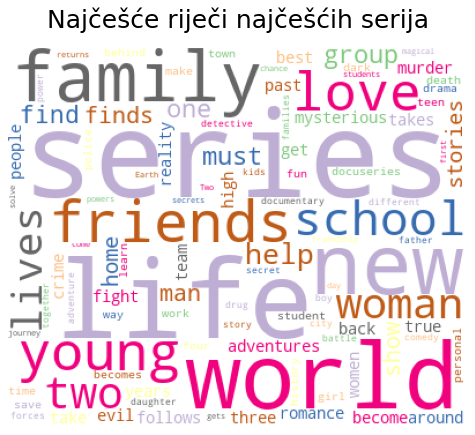

In [370]:
from wordcloud import WordCloud
fig = plt.figure(figsize=(15, 7))

wc1 = WordCloud(width=400, height=330, max_words=100, colormap="Accent", background_color="white").generate_from_frequencies(counter_words1)


plt.imshow(wc1)
plt.axis("off")
plt.title("Najčešće riječi najčešćih serija", fontsize=25, pad=20);

**Koje riječi se najčešće pojavljuju u opisima 10 najmanje čestih kategorija serija?**

In [371]:
desc_s=tags_s[tags_s["listed_in"].isin(tags_s_count.keys()[-10:])]
desc_s=desc_s.description.to_numpy()
desc_s=[*set(desc_s)]
sentences_with_words = word_tokenizer.tokenize_sents(desc_s)
words = [word for sentence in sentences_with_words for word in sentence]

from collections import Counter
counter_words2 = Counter()

for word in words:
    if word.lower() not in stop_words and word.isalnum():
      counter_words2.update({word})

counter_words2.most_common(10)

[('series', 78),
 ('world', 50),
 ('life', 50),
 ('new', 49),
 ('school', 42),
 ('family', 36),
 ('young', 34),
 ('two', 31),
 ('mysterious', 30),
 ('love', 30)]

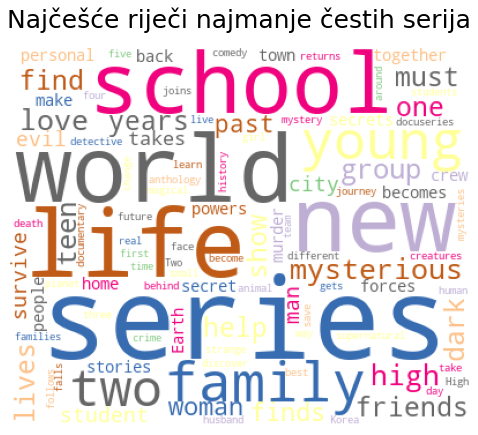

In [372]:
from wordcloud import WordCloud
fig = plt.figure(figsize=(15, 7))

wc1 = WordCloud(width=400, height=330, max_words=100, colormap="Accent", background_color="white").generate_from_frequencies(counter_words2)


plt.imshow(wc1)
plt.axis("off")
plt.title("Najčešće riječi najmanje čestih serija", fontsize=25, pad=20);

Pokušajmo grupirati podatke (clustering).<br>
Grupirati ćemo različite riječi koje se pojavljuju u opisima.<br><br>
U *desc* spremimo sve opise.

In [373]:
desc=[]
desc.extend(desc_m)
desc.extend(desc_m)

Prije nego što treniramo naš KMeans model, transformiramo opise, koji su stringovi, u vektore.<br>
Uzimimo npr. 5 jezgri takvih da će svaka predstavljati neki žanr (koji ćemo mi odabrati). 

In [374]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(desc)
k_means = KMeans(n_clusters=5, random_state=7)
k_means.fit(X)

KMeans(n_clusters=5, random_state=7)

U *categories* spremamo nazive grupa. Nazive grupa (žanrove) biramo sami na način da promotrimo elemente grupe i procjenimo kojem bi žanru mogli pripadati. (Alternativno smo mogli samo nazvati grupe: GRUPA 1, GRUPA 2...) <br>
Za svaku od 5 grupa ćemo ispisati 5 najčešćih riječi po grupi.<br>
Npr. za jezgru 0 imamo riječi: "stand", "speacial", "comedy" ... , pa ćemo ovu grupu nazvati "COMEDY". <br>

In [424]:
categories = {0 : "COMEDY",
          1: "SPORT",
          2: "DOCUMENTARY",
          3: "FAMILY",
          4: "DRAMA",
          }

In [425]:
print("Najčešće riječi po grupi:")
centri = k_means.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(5):
    print("Cluster %d:" % i)
    print("GROUP: ",categories[i])
    for ind in centri[i, :5]:
        print(terms[ind])
    print("---")

Najčešće riječi po grupi:
Cluster 0:
GROUP:  COMEDY
stand
special
comedian
comedy
comic
---
Cluster 1:
GROUP:  SPORT
soccer
lives
team
players
professional
---
Cluster 2:
GROUP:  DOCUMENTARY
life
new
world
documentary
group
---
Cluster 3:
GROUP:  FAMILY
family
home
new
events
stand
---
Cluster 4:
GROUP:  DRAMA
young
man
friend
woman
help
---


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


#O godinama izlaska i postavljanja

U *god_tag* spremimo godinu izlaska filma/serije i kategorije.

In [426]:
god_tag=data[["release_year","listed_in"]]

**Koje godine je izašlo najviše filmova/serija?**<br><br>
2018.

In [427]:
god_tag["release_year"].value_counts()

2018    1147
2017    1032
2019    1030
2020     953
2016     902
        ... 
1959       1
1925       1
1961       1
1947       1
1966       1
Name: release_year, Length: 74, dtype: int64

Zanimat će nas i što je bila najpopularnija kategorija ovisno o godini izlaska. Brojimo koliko radova je izašlo koje godine.

In [428]:
god_tag.listed_in = god_tag.listed_in.str.split(', ')                                                               
god_tag=god_tag.explode('listed_in')
god_tag_count=god_tag.value_counts()
god_tag_count

/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


release_year  listed_in           
2018          International Movies    340
2017          International Movies    328
2016          International Movies    305
2018          Dramas                  304
2017          Dramas                  285
                                     ... 
1992          Kids' TV                  1
              Romantic Movies           1
              Sci-Fi & Fantasy          1
2011          Teen TV Shows             1
1925          TV Shows                  1
Length: 1192, dtype: int64

**Koja je najčešća kategorija ovisno o godini izlaska?**
<br><br>
(Kod dolje) *Format:* Godina(kronološki)  Najzastupljenija_kategorija     (Broj_djela_te_kategorije)
<br><br>
Uočimo da najviše filmova/serija ima zadnjih par godina i da prevladavaju internacionalni filmovi.

In [380]:
for k in sorted(god_tag["release_year"].unique()):
  print(k," ",god_tag_count[k].index[0]," (",god_tag_count[k][0],")")

1925   TV Shows  ( 1 )
1942   Classic Movies  ( 2 )
1943   Documentaries  ( 3 )
1944   Classic Movies  ( 3 )
1945   Documentaries  ( 3 )
1946   Documentaries  ( 1 )
1947   Documentaries  ( 1 )
1954   Classic Movies  ( 2 )
1955   Classic Movies  ( 3 )
1956   Classic Movies  ( 2 )
1958   Classic Movies  ( 3 )
1959   Dramas  ( 1 )
1960   Dramas  ( 3 )
1961   Classic Movies  ( 1 )
1962   Dramas  ( 3 )
1963   TV Sci-Fi & Fantasy  ( 1 )
1964   Classic Movies  ( 2 )
1965   Dramas  ( 2 )
1966   Music & Musicals  ( 1 )
1967   Dramas  ( 4 )
1968   Classic Movies  ( 3 )
1969   Dramas  ( 2 )
1970   International Movies  ( 2 )
1971   Classic Movies  ( 4 )
1972   Classic Movies  ( 2 )
1973   International Movies  ( 5 )
1974   Comedies  ( 4 )
1975   International Movies  ( 5 )
1976   Dramas  ( 4 )
1977   Dramas  ( 2 )
1978   International Movies  ( 4 )
1979   Classic Movies  ( 6 )
1980   Action & Adventure  ( 6 )
1981   International Movies  ( 5 )
1982   International Movies  ( 10 )
1983   Internatio

Promotrimo npr. 2018. kao godinu s najviše izlazaka.<br><br>
**S koliko različitih kategorija postoji filmova/serija te godine?**

In [381]:
print("U 2018. imamo",len(god_tag_count[2018]),"različitih kategorija.")

U 2018. imamo 41 različitih kategorija.


Sjetimo se da ukupno postoje 42 različite kategorije, što znači da samo jedna vrsta filma/serije nije postavljena na Netflix te godine. <br>
Pogledajmo koja (kod dolje). <br><br>
Te godine nije postavljen niti jedan TV Show.

In [382]:
for t in tags.keys():
  if(t not in god_tag_count[2018].keys()):
    print(t)

TV Shows


Vizualizirajmo još podatke za 2018. godinu.

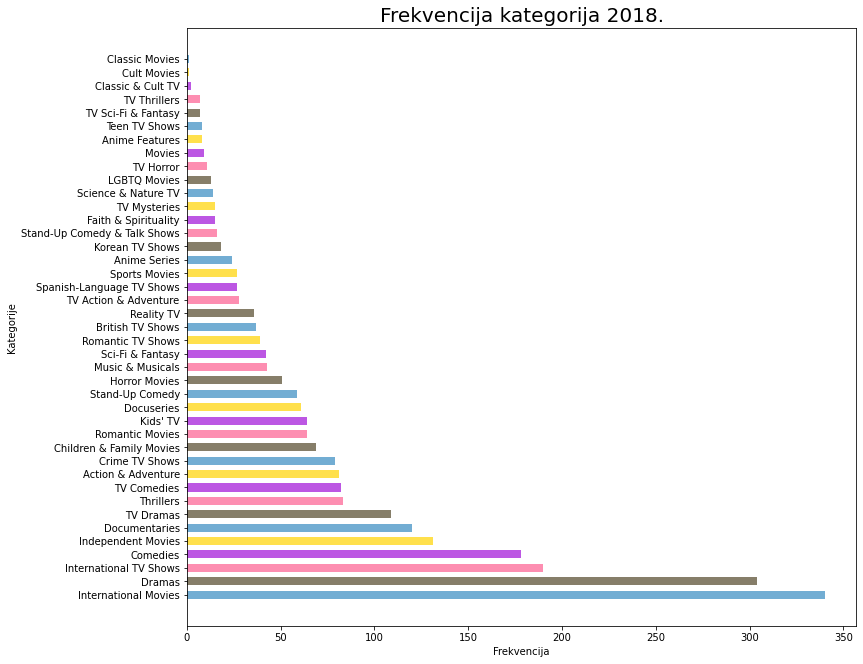

In [383]:
plt.subplots(figsize=(12, 11)) 
plt.barh(y=god_tag_count[2018].keys(), width= god_tag_count[2018].values, height=0.6, alpha = 0.7, color=['#368BC1', '#53472A', '#FD5E90', '#A010D8', '#FFD400'])

plt.xlabel('Frekvencija')
plt.ylabel('Kategorije')
plt.title('Frekvencija kategorija 2018.')

plt.show()

Želimo vizualizirati ukupne podatke vezane za godinu izlaska. Radi urednijeg prikaza stvaramo novi DataFrame koji će imat kronološki sortirane godine.

In [384]:
god_tag_graf=pd.DataFrame()
god_tag_graf["year"]=sorted(god_tag.release_year.unique())

Grafički ćemo prikazati odnos godine izlaska i 5 najčešćih kategorija na Netflixu. (Odabiremo prvih 5 zbog čišće vizualizacije i činjenice da za tih 5 imamo najviše podataka.<br><br>
U dictionary *dicti1* kao ključeve postavljamo imena 5 najčešćih kategorija na Netflixu. Tim kategorijama (ključevima) pridružujemo listu brojeva gdje svaki broj predstavlja broj pojavljivanja te kategorije ovisno o pojedinačnoj godini.

In [385]:
dicti1={}
for f in tags.keys()[:5]:  #za svaku od 5 kategorija stvaramo listu
  dicti1[f]=[]

br=0
for y in god_tag_graf.year:
  br+=1
  for name in god_tag_count[y].index:
    if name in dicti1.keys():
      dicti1[name].append(god_tag_count[y][god_tag_count[y].index==name][0]) #za svaku godinu provjeravamo ima li tražemu kategoriju i ako ima dodajemo broj pojavljivanja na listu
  for podlis in dicti1.keys():
    if(len(dicti1[podlis])!=br):
      dicti1[podlis].append(0) #ako se kategorija ne pojavljuje dodajemo da se pojavljuje 0 puta
    
    

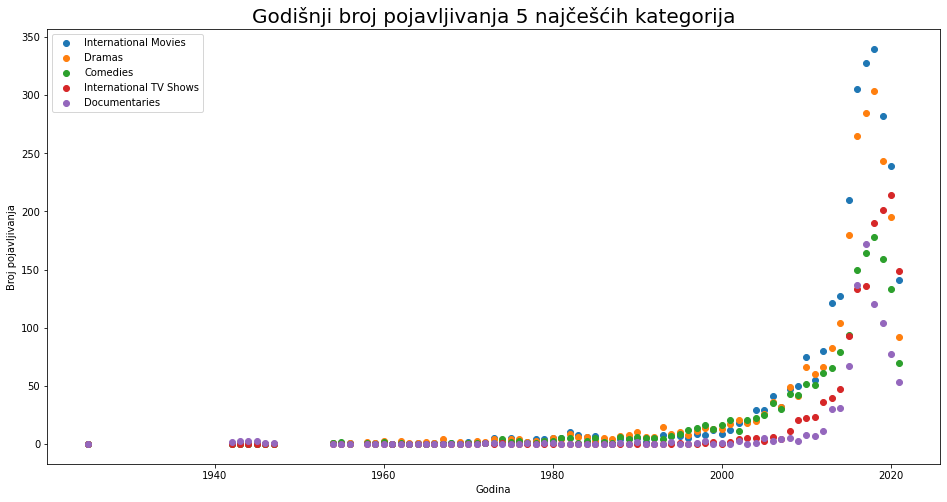

In [386]:
from matplotlib import legend
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))

legend=[]
for t in tags.keys()[:5]:
  plt.scatter(sorted(god_tag["release_year"].unique()),dicti1[t])
 
  legend.append(t)

plt.rc('axes', titlesize=20) 
plt.title('Godišnji broj pojavljivanja 5 najčešćih kategorija')
plt.xlabel('Godina')
plt.ylabel('Broj pojavljivanja')
plt.legend(legend, loc=2)
plt.show()

Grafički prikažimo i usporedbu godina izlaska i godina dodavanja.<br>
Gledat ćemo samo podatke vezane za filmove jer se kod serija bilježi godina izlaska zadnje sezone, a nas u ovom slučaju zanima kad je prvi put izašlo.<br>
U *odnos_dodavanja* spremamo sve datume dodavanja filmova(koji nisu NaN) i godine izlaska.

In [387]:
odnos_dodavanja=pd.DataFrame(movies[movies.date_added.notna()][["date_added","release_year"]])

Preoblikujmo podatke tako da umjesto datuma dodavanja ostavimo samo godinu dodavanja.

In [388]:
for i in odnos_dodavanja.index:
    odnos_dodavanja.at[i,'date_added']=int(odnos_dodavanja["date_added"][i][-4:]) #uzimamo samo godinu
odnos_dodavanja=odnos_dodavanja.rename(columns={"date_added":"year_added"}) #preimenujmo u year_added

In [389]:
odnos_dodavanja.head()

,year_added,release_year
0,2021,2020
6,2021,2021
7,2021,1993
9,2021,2021
12,2021,2021


**U kojoj godini je izašlo najviše filmova?**<br><br>
2017. i 2018. dijele prvo mjesto s 767 filmova.

In [390]:
temp=odnos_dodavanja["release_year"].value_counts()
temp

2017    767
2018    767
2016    658
2019    633
2020    517
       ... 
1966      1
1961      1
1946      1
1963      1
1947      1
Name: release_year, Length: 73, dtype: int64

Vizualizirajmo podatke o broju izlazaka filmova u odnosu na godine.<br><br>
Većina filmova na Netflixu je izašla poslije 2010. godine.

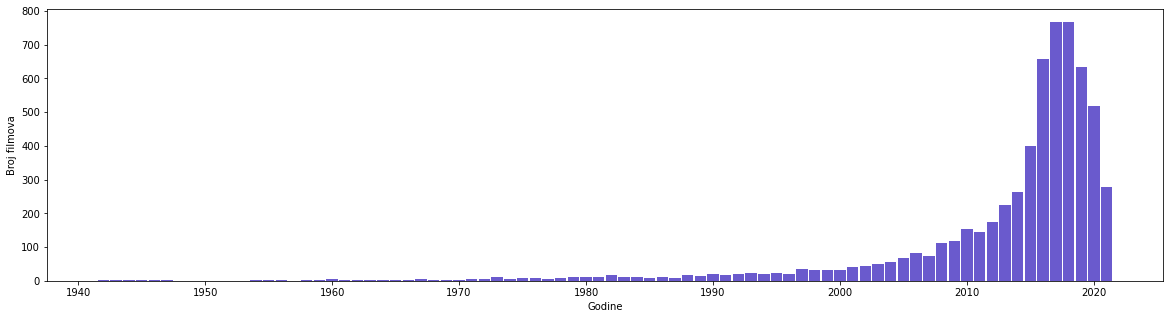

In [391]:
plt.figure(figsize=(20,5))
plt.bar(x=list(temp.keys()), height=list(temp.values), width=0.9,color="SlateBlue")
plt.xlabel("Godine")
plt.ylabel("Broj filmova")
plt.show()

U *odnos_dodavanja* dodajmo stupac *difference* koji nam govori koliko godina razlike ima između godine izlaska filma i godine njegovog dodavanja na Netflix. <br>
Dovoljno je izračunati godina_dodavanja - godina_izlaska jer će to većinom biti broj >=0.
<br>
(Ovo je bio razlog izbacivanja serija. Kod njih bi dobivali i negativne vrijednosti.)

In [392]:
odnos_dodavanja['difference'] = odnos_dodavanja.apply(lambda row: row.year_added -
                                  row.release_year, axis = 1)

In [393]:
temp=odnos_dodavanja["difference"].value_counts()

**Postoje li filmovi koji su postavljeni na Netflix prije službenog izlaska?**<br><br>
Postoje 2 takva filma : "Hans Teeuwen: Real Rancour" i "Incoming".

In [394]:
len(odnos_dodavanja[odnos_dodavanja.difference==-1])

2

In [395]:
data[(data.index==5394) | (data.index==7063)]["title"]

5394    Hans Teeuwen: Real Rancour
7063                      Incoming
Name: title, dtype: object

Vizualizirajmo razlike.<br><br>
Najviše filmova je postavljeno na Netflix iste godine kada su izašli ili godinu kasnije. <br>
Ovo ima smisla ako pogledamo prethodni graf koji nam prikazuje da je najviše filmova i izašlo zadnjih par godina. 

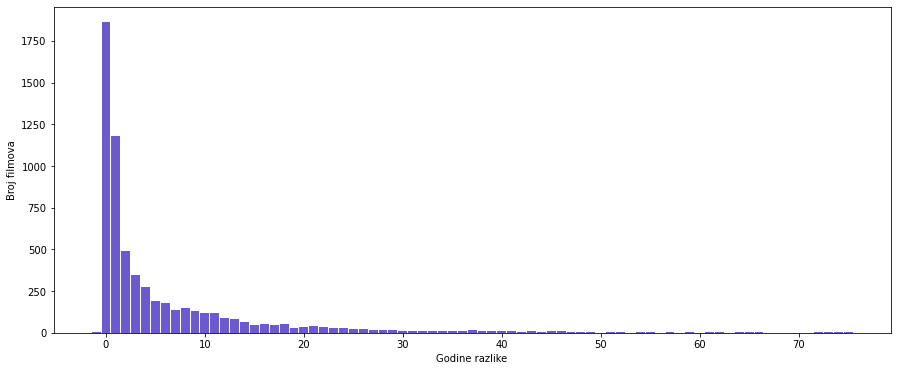

In [396]:
plt.figure(figsize=(15,6))
plt.bar(x=list(temp.keys()), height=list(temp.values), width=0.9,color="SlateBlue")
plt.xlabel("Godine razlike")
plt.ylabel("Broj filmova")
plt.show()

**Kojim filmovim je trebalo najviše vremena da ih se stavi na Netflix?**<br>
Alternativno, **koji su najstariji filmovi na Netflix-u?** <br><br>
Pogledajmo sve filmove čija je razlika dodavanja u godinama veća od 70. Takvih filmova ima 12. 

In [397]:
indexi=odnos_dodavanja[odnos_dodavanja.difference>70].index
data.loc[indexi][["title","release_year"]]

,title,release_year
7219,Know Your Enemy - Japan,1945
7294,Let There Be Light,1946
7575,Nazi Concentration Camps,1945
7790,Prelude to War,1942
7930,San Pietro,1945
8205,The Battle of Midway,1942
8419,The Memphis Belle: A Story of a\nFlying Fortress,1944
8436,The Negro Soldier,1944
8640,Tunisian Victory,1944
8660,Undercover: How to Operate Behind Enemy Lines,1943


In [398]:
print("Najveća razlika u godinama postavljanja i izlaska : ",odnos_dodavanja[odnos_dodavanja.difference==odnos_dodavanja["difference"].max()]["difference"].values[0])

Najveća razlika u godinama postavljanja i izlaska :  75


**Nazivi najstarijih filmova (oba iz godine 1942)?**<br><br>
"Prelude to War" i "The Battle of Midway".

In [399]:
data.loc[odnos_dodavanja[odnos_dodavanja.difference==odnos_dodavanja["difference"].max()].index]["title"]

7790          Prelude to War
8205    The Battle of Midway
Name: title, dtype: object

#Duljina filmova/serija

U *duljina_film* i *duljina_serija* spremimo nazive i duljine trajanja (koje nisu NaN) filmova i serija.

In [400]:
duljina_film=movies[movies.duration.notna()][["title","duration"]]
duljina_serija=series[series.duration.notna()][["title","duration"]]

**Različite duljine trajanja serija?**<br>
(Format: {broj} Seasons)<br>
Broj sezona.

In [401]:
duljina_serija["duration"].unique()

array(['2 Seasons', '1 Season', '9 Seasons', '4 Seasons', '5 Seasons',
       '3 Seasons', '6 Seasons', '7 Seasons', '10 Seasons', '8 Seasons',
       '17 Seasons', '13 Seasons', '15 Seasons', '12 Seasons',
       '11 Seasons'], dtype=object)

**Različite duljine trajanja filmova?**<br>
(Format: {broj} min)<br>
Minutaža.

In [402]:
duljina_film["duration"].unique()

array(['90 min', '91 min', '125 min', '104 min', '127 min', '67 min',
       '94 min', '161 min', '61 min', '166 min', '147 min', '103 min',
       '97 min', '106 min', '111 min', '110 min', '105 min', '96 min',
       '124 min', '116 min', '98 min', '23 min', '115 min', '122 min',
       '99 min', '88 min', '100 min', '102 min', '93 min', '95 min',
       '85 min', '83 min', '113 min', '13 min', '182 min', '48 min',
       '145 min', '87 min', '92 min', '80 min', '117 min', '128 min',
       '119 min', '143 min', '114 min', '118 min', '108 min', '63 min',
       '121 min', '142 min', '154 min', '120 min', '82 min', '109 min',
       '101 min', '86 min', '229 min', '76 min', '89 min', '156 min',
       '112 min', '107 min', '129 min', '135 min', '136 min', '165 min',
       '150 min', '133 min', '70 min', '84 min', '140 min', '78 min',
       '64 min', '59 min', '139 min', '69 min', '148 min', '189 min',
       '141 min', '130 min', '138 min', '81 min', '132 min', '123 min',
       '65

Želimo da nam ostanu samo brojčane vrijednosti, pa preoblikujmo vrijednosti tako da maknemo "min"/"Season(s)".

In [403]:
for i in duljina_film.index:
    duljina_film.at[i,'duration']=int(duljina_film["duration"][i].split(" ")[0]) #da maknemo min dio i prebacimo u int
  
for i in duljina_serija.index:
    duljina_serija.at[i,'duration']=int(duljina_serija["duration"][i].split(" ")[0]) #da maknemo Season(s) dio i prebacimo u int

**Koji je najdulji film i koja je njegova minutaža?**<br><br>
Najdulji film je "Black Mirror: Bandersnatch" koji traje 312 minuta. 

In [404]:
duljina_film.loc[duljina_film.duration==duljina_film.duration.max()]

,title,duration
4253,Black Mirror: Bandersnatch,312


**Koji je najkraći film i koja je njegova minutaža?**<br><br>
Najkraći film je "Silent" koji traje 3 minute. 

In [405]:
duljina_film.loc[duljina_film.duration==duljina_film.duration.min()]

,title,duration
3777,Silent,3


**Koja serija ima najviše sezona i koliko?**<br><br>
Najviše sezona ima "Grey's Anatomy" - 17 sezona.

In [406]:
duljina_serija.loc[duljina_serija.duration==duljina_serija.duration.max()]

,title,duration
548,Grey's Anatomy,17


**Koja serija ima najmanje sezona i koliko?**<br><br>
Najkraći broj sezona je 1, a njih čak 1793 ima jednu sezonu. 

In [407]:
duljina_serija.loc[duljina_serija.duration==duljina_serija.duration.min()]

,title,duration
2,Ganglands,1
3,Jailbirds New Orleans,1
5,Midnight Mass,1
10,"Vendetta: Truth, Lies and The Mafia",1
11,Bangkok Breaking,1
...,...,...
8775,Yeh Meri Family,1
8780,Yo-Kai Watch,1
8783,Yoko,1
8785,YOM,1


#Ovisnost mjeseca dodavanja i kategorije

U *month* spremimo datum dodavanja i kategorije.

In [408]:
month=data[data.date_added.notna()][["date_added","listed_in"]]

In [409]:
month.head()

,date_added,listed_in
0,"September 25, 2021",Documentaries
1,"September 24, 2021","International TV Shows, TV Dramas, TV Mysteries"
2,"September 24, 2021","Crime TV Shows, International TV Shows, TV Act..."
3,"September 24, 2021","Docuseries, Reality TV"
4,"September 24, 2021","International TV Shows, Romantic TV Shows, TV ..."


Iz stupca *date_added* izvucimo mjesece dodavanja i spremimo ih u listu *mjeseci* koju ćemo spremiti u novi stupac *month*.<br><br>
Pošto *date_added* ima za vrijednosti stringove u formatu "Month Day, Year" (neki " Month Day, Year" sa razmakom ispred) dovoljno je napraviti split po razmaku i uzeti prvi element (drugi ako datum ima razmak ispred mjeseca).

In [410]:
temp=month.date_added.to_numpy() #pretvaramo stupac date_added u numpy
mjeseci=[]
for t in temp:
  if(t.split(" ")[0]!=""):
    mjeseci.append(t.split(" ")[0]) 
  else:
    mjeseci.append(t.split(" ")[1]) #jer neki datumi imaju space ispred

In [411]:
month["month"]=mjeseci

Provjerimo ima li NaN vrijednosti.<br><br>
Nema.

In [412]:
month.isna().any(axis=0)

date_added    False
listed_in     False
month         False
dtype: bool

Proširimo po kategoriji kao i prije.

In [413]:
month.listed_in = month.listed_in.str.split(', ')                                                               
month=month.explode('listed_in')

month

,date_added,listed_in,month
0,"September 25, 2021",Documentaries,September
1,"September 24, 2021",International TV Shows,September
1,"September 24, 2021",TV Dramas,September
1,"September 24, 2021",TV Mysteries,September
2,"September 24, 2021",Crime TV Shows,September
...,...,...,...
8805,"January 11, 2020",Children & Family Movies,January
8805,"January 11, 2020",Comedies,January
8806,"March 2, 2019",Dramas,March
8806,"March 2, 2019",International Movies,March


Kreirajmo crosstab *month_crtb* s kojim ćemo brojiti broj kategorija po mjesecu. <br>
Npr. u travnju je dodano 156 komedija.

In [414]:
month_crtb=pd.crosstab(month["month"],month["listed_in"], rownames=["Months"], colnames=["Tags"])

In [415]:
month_crtb

Tags,Action & Adventure,Anime Features,Anime Series,British TV Shows,Children & Family Movies,Classic & Cult TV,Classic Movies,Comedies,Crime TV Shows,Cult Movies,...,TV Action & Adventure,TV Comedies,TV Dramas,TV Horror,TV Mysteries,TV Sci-Fi & Fantasy,TV Shows,TV Thrillers,Teen TV Shows,Thrillers
Months,,,,,,,,,,,,,,,,,,,,,
April,70,4,20,20,56,0,2,170,35,4,...,11,60,56,6,5,9,1,5,4,47
August,86,3,12,22,41,2,7,156,48,7,...,10,39,74,5,12,8,1,5,6,53
December,68,4,20,24,62,5,10,160,41,6,...,12,67,78,7,9,6,2,8,8,47
February,46,5,9,18,33,0,2,87,42,1,...,13,35,53,6,4,1,3,2,6,42
January,79,4,11,13,63,2,18,152,27,12,...,17,42,48,4,2,8,1,6,3,51
July,83,4,15,32,65,6,9,145,36,5,...,24,51,75,6,12,14,1,3,6,60
June,72,12,22,11,42,2,13,121,45,5,...,14,41,78,9,14,5,3,5,8,47
March,61,3,13,36,53,3,14,134,47,5,...,9,33,64,6,9,3,0,3,3,39
May,54,4,10,10,43,1,1,129,34,3,...,16,47,61,9,6,9,1,5,1,45


U listu *mnt* dodajmo imena mjeseci i mijenjamo indexe u *month_crtb* u ovisnosti s *mnt* kako bi mjeseci bili izlistani po redu radi bolje vizualizacije.

In [416]:
mnt=["January","February","March","April","May","June","July","August","September","October","November","December"]

In [417]:
month_crtb = month_crtb.reindex(mnt, axis="rows")

In [418]:
month_crtb

Tags,Action & Adventure,Anime Features,Anime Series,British TV Shows,Children & Family Movies,Classic & Cult TV,Classic Movies,Comedies,Crime TV Shows,Cult Movies,...,TV Action & Adventure,TV Comedies,TV Dramas,TV Horror,TV Mysteries,TV Sci-Fi & Fantasy,TV Shows,TV Thrillers,Teen TV Shows,Thrillers
Months,,,,,,,,,,,,,,,,,,,,,
January,79,4,11,13,63,2,18,152,27,12,...,17,42,48,4,2,8,1,6,3,51
February,46,5,9,18,33,0,2,87,42,1,...,13,35,53,6,4,1,3,2,6,42
March,61,3,13,36,53,3,14,134,47,5,...,9,33,64,6,9,3,0,3,3,39
April,70,4,20,20,56,0,2,170,35,4,...,11,60,56,6,5,9,1,5,4,47
May,54,4,10,10,43,1,1,129,34,3,...,16,47,61,9,6,9,1,5,1,45
June,72,12,22,11,42,2,13,121,45,5,...,14,41,78,9,14,5,3,5,8,47
July,83,4,15,32,65,6,9,145,36,5,...,24,51,75,6,12,14,1,3,6,60
August,86,3,12,22,41,2,7,156,48,7,...,10,39,74,5,12,8,1,5,6,53
September,93,21,13,27,59,3,6,139,48,9,...,19,55,73,9,12,10,1,8,5,56


Intuitivno se nalaže da bi mogla postojati ovisnost između datuma dodavanja na Netflix i kategorije filmova/serija (npr. zbog blagdana, godišnjih doba itd.) . <br><br>
Vizalizirajmo podatke za neke kategorije.<br>
Pogledajmo kategoriju "Anime Features". Daleko najviše anime filmova je izašlo u rujnu.

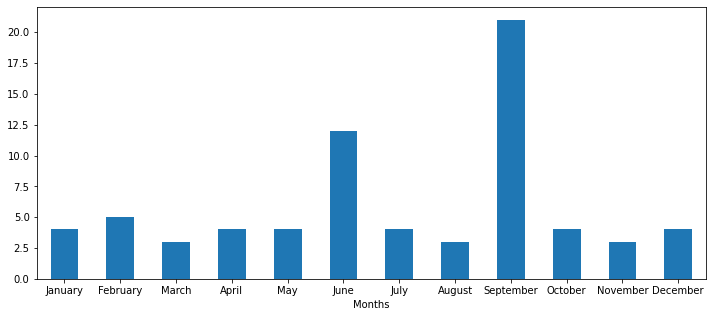

In [419]:
plt.figure(figsize=(12,5))
barplot = month_crtb["Anime Features"].plot.bar(rot=0)

Npr. Najviše kultnih filmova je dodano u siječnju.

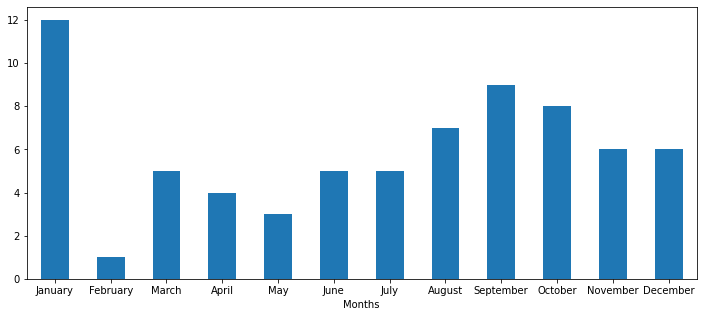

In [420]:
plt.figure(figsize=(12,5))
barplot = month_crtb["Cult Movies"].plot.bar(rot=0)

**Ovisi li kategorija filma/serije o mjesecu dodavanja na Netflix?**

Hipoteze:
> * $H_0$: kategorija filma ne ovisi o mjesecu dodavanja
> * $H_1$: kategorija filma ovisi o mjesecu dodavanja

Uzmimo da je razina značajnosti $\alpha = P(pogreška \hspace{1mm}prve \hspace{1mm} vrste)=0.05$.<br>



Koristit ćemo neparametarsku (nema prepostavke o parametrima) testnu statistiku *Chi-Squared*. Ova testna statistika provjerava jesu li dvije kategoričke vrijednosti ovisne jedna o drugoj (u našem slučaju mjesec i kategorija).<br>
Ovaj test radi s "contingency" tablicama (crosstab) i uspoređuje naše frekvencije s očekivanim frekvencijama.<br><br>
Kod ovakve statistike, nul-hipoteza pretstavlja neovisnost.

In [421]:
chi2,pvalue,dof,ex = stats.chi2_contingency(month_crtb)
print(f"pvalue: {pvalue}")
print(f"pvalue < 0.05: {pvalue < 0.05}")

pvalue: 5.611705756978267e-17
pvalue < 0.05: True


$p$-vrijednost je manja od $\alpha$, pa odbacujemo nultu hipotezu tj. vrlo je vjerojatno da kategorija ovisi o mjesecu dodavanja.